In [1]:
from tqdm import tqdm
import time
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
feat_dir  = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/audio_features'
label_dir = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/labels'
split_csv = '/home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/data_split_tang.csv'

split_df = pd.read_csv(split_csv)
groups   = {s: split_df[split_df['split']==s]['filename'].tolist()
            for s in ['train','val','test']}

selected_feats = ['mfcc','embeddings','contrast','flatness', 'bandwidth', 'melspectrogram']
feature_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=47))
])

def load_features_and_labels(filenames, cls):
    X_list, y_list = [], []
    for fn in tqdm(filenames, desc=f"Loading {cls}"):
        arr = np.load(os.path.join(feat_dir, fn.replace('.mp3','.npz')))
        Xf = np.concatenate([arr[f] for f in selected_feats], axis=1)
        lab = np.load(os.path.join(label_dir, fn.replace('.mp3','_labels.npz')))[cls]
        votes = (lab.sum(axis=1) >= np.ceil(lab.shape[1]/2)).astype(int)
        X_list.append(Xf)
        y_list.append(votes)
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

selected_class = 'Speech'

t0 = time.time()
X_train, y_train = load_features_and_labels(groups['train'], selected_class)
X_val,   y_val   = load_features_and_labels(groups['val'],   selected_class)
load_end = time.time()

pt0 = time.time()
X_train_prep = feature_pipeline.fit_transform(X_train)
X_val_prep   = feature_pipeline.transform(X_val)
prep_end = time.time()

print(f"Loading time: {load_end-t0:.1f}s, Preprocessing time: {prep_end-pt0:.1f}s")

Loading Speech: 100%|██████████| 1234/1234 [00:02<00:00, 556.48it/s]


Loading time: 19.4s, Preprocessing time: 19.4s


SVM grid search: 100%|██████████| 5/5 [03:49<00:00, 45.90s/it]


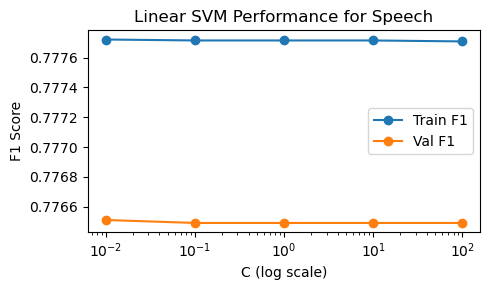

        C  train_time_s  F1_train    F1_val
0    0.01     45.106345  0.777721  0.776511
1    0.10     46.034055  0.777714  0.776491
2    1.00     45.674620  0.777714  0.776491
3   10.00     44.641157  0.777714  0.776491
4  100.00     45.739950  0.777708  0.776491


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

Cs = [0.01, 0.1, 1, 10, 100]
records = []

for C in tqdm(Cs, desc="SVM grid search"):
    clf = LinearSVC(C=C, max_iter=5000, random_state=47)
    t_start = time.time()
    clf.fit(X_train_prep, y_train)
    t_end = time.time()
    train_time = t_end - t_start

    y_tr = clf.predict(X_train_prep)
    y_vl = clf.predict(X_val_prep)
    f1_tr = f1_score(y_train, y_tr, average='binary')
    f1_vl = f1_score(y_val,   y_vl, average='binary')

    records.append((C, train_time, f1_tr, f1_vl))

df_res = pd.DataFrame(records, columns=['C','train_time_s','F1_train','F1_val'])
plt.figure(figsize=(5,3))
plt.plot(df_res['C'], df_res['F1_train'], marker='o', label='Train F1')
plt.plot(df_res['C'], df_res['F1_val'],   marker='o', label='Val F1')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('F1 Score')
plt.title(f'Linear SVM Performance for {selected_class}')
plt.legend()
plt.tight_layout()
plt.show()

print(df_res)

c do not have much impact on the training. I will just use c=1 for training in next step

no significant underfiting or overfiting accros differernt c.


DT max_depth grid:   0%|          | 0/5 [00:00<?, ?it/s]

DT max_depth grid: 100%|██████████| 5/5 [1:13:19<00:00, 879.92s/it] 


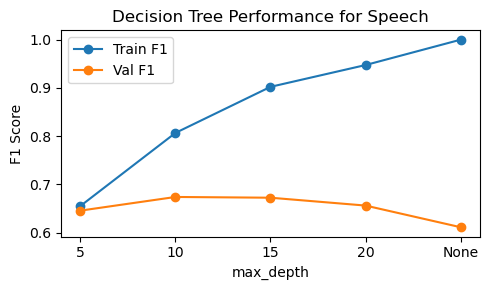

  max_depth  train_time_s  F1_train    F1_val
0         5    223.512794  0.655481  0.645844
1        10    437.827267  0.806861  0.674144
2        15    635.117198  0.902333  0.672591
3        20    820.021551  0.947486  0.656322
4      None   2279.735260  1.000000  0.611478


In [ ]:
from sklearn.tree import DecisionTreeClassifier

depths = [5, 10, 15, 20, None]
dt_records = []

for d in tqdm(depths, desc="DT max_depth grid"):
    clf = DecisionTreeClassifier(max_depth=d, random_state=47)
    t0 = time.time()
    clf.fit(X_train_prep, y_train)
    t1 = time.time()

    # 预测并计算 F1
    f1_tr = f1_score(y_train, clf.predict(X_train_prep), average='binary')
    f1_vl = f1_score(y_val,   clf.predict(X_val_prep),   average='binary')

    dt_records.append((str(d), t1-t0, f1_tr, f1_vl))

df_dt = pd.DataFrame(dt_records, columns=['max_depth','train_time_s','F1_train','F1_val'])

plt.figure(figsize=(5,3))
plt.plot(df_dt['max_depth'], df_dt['F1_train'], marker='o', label='Train F1')
plt.plot(df_dt['max_depth'], df_dt['F1_val'],   marker='o', label='Val F1')
plt.xlabel('max_depth')
plt.ylabel('F1 Score')
plt.title('Decision Tree Performance for Speech')
plt.legend()
plt.tight_layout()
plt.show()

print(df_dt)

max_depth =10 best

ok training time, best training F1 score, best validation F1 score

at max_depth=5 underfitting, not capture the pattern enough. at max_depth=15,20,none overfiting occurs.

SGD alpha grid:  33%|███▎      | 2/6 [01:51<03:19, 49.90s/it]/home/mtang/miniconda3/envs/mlpc2025/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
SGD alpha grid: 100%|██████████| 6/6 [14:33<00:00, 145.59s/it]


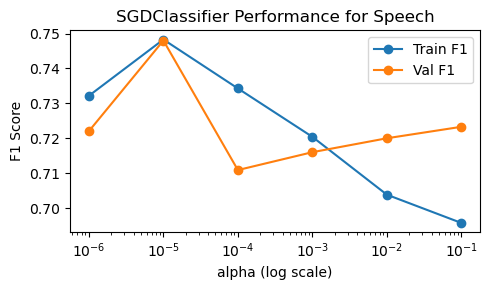

      alpha  train_time_s  F1_train    F1_val
0  0.000001     87.987899  0.732176  0.722041
1  0.000010     22.821191  0.748288  0.747997
2  0.000100    596.223741  0.734277  0.710905
3  0.001000    136.391872  0.720411  0.716020
4  0.010000     22.955401  0.703851  0.720009
5  0.100000      5.659811  0.695757  0.723293


In [9]:
from sklearn.linear_model import SGDClassifier

alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
records = []

for a in tqdm(alphas, desc="SGD alpha grid"):
    clf = SGDClassifier(
        loss='log_loss',     
        penalty='l2',
        alpha=a,
        max_iter=1000,
        tol=1e-3,
        random_state=47
    )
    t0 = time.time()
    clf.fit(X_train_prep, y_train)
    t1 = time.time()
    
    f1_tr = f1_score(y_train, clf.predict(X_train_prep), average='binary')
    f1_vl = f1_score(y_val,   clf.predict(X_val_prep),   average='binary')
    records.append((a, t1 - t0, f1_tr, f1_vl))

df_sgd = pd.DataFrame(records, columns=['alpha','train_time_s','F1_train','F1_val'])

plt.figure(figsize=(5,3))
plt.plot(df_sgd['alpha'], df_sgd['F1_train'], marker='o', label='Train F1')
plt.plot(df_sgd['alpha'], df_sgd['F1_val'],   marker='o', label='Val F1')
plt.xscale('log')
plt.xlabel('alpha (log scale)')
plt.ylabel('F1 Score')
plt.title('SGDClassifier Performance for Speech')
plt.legend()
plt.tight_layout()
plt.show()

print(df_sgd)

best alpha=1e-5, train and val both reach highest F1 score 0.748, training time acceptable.

alpha=1e-6, underfitting. training time acceptable.

alpha=1e-4, alpha=1e-5, underfitting, training time increase, especially alpha=1e-4, almost 30 times to alpha=1e-5.

alpha=1e-2,alpha=1e-1, overfitting. training time ok.




Linear SVM best c=1, f1 best 0.775
Decision Tree best max_depth=10, f1 best 0.674
SGDClassifier best alpha=1e-5, f1 best 0.748

Linear SVM slow, SGDClassifier fast



next step train with Linear SVM

In [ ]:
import os, time
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from joblib import Parallel, delayed, dump

feat_dir   = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/audio_features'
label_dir  = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/labels'
split_csv  = '/home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/data_split_tang.csv'
out_dir    = '/home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/models'
os.makedirs(out_dir, exist_ok=True)

split_df    = pd.read_csv(split_csv)
train_files = split_df[split_df['split']=='train']['filename'].tolist()
first_lab   = np.load(os.path.join(label_dir, train_files[0].replace('.mp3','_labels.npz')))
classes     = list(first_lab.keys())


selected_feats = ['mfcc','embeddings','contrast','flatness', 'bandwidth', 'melspectrogram']

X_parts, Y_parts = [], []
for fn in tqdm(train_files, desc="Loading train data"):
    arr = np.load(os.path.join(feat_dir, fn.replace('.mp3','.npz')))
    Xf  = np.concatenate([arr[f] for f in selected_feats], axis=1)  # (T, D)
    X_parts.append(Xf)
    labs_npz = np.load(os.path.join(label_dir, fn.replace('.mp3','_labels.npz')))
    votes = [ (labs_npz[c].sum(axis=1) >= np.ceil(labs_npz[c].shape[1]/2)).astype(int)
              for c in classes ]
    Y_parts.append(np.vstack(votes).T)  # (T,58)

X_train_orig = np.vstack(X_parts)        
Y_train      = np.vstack(Y_parts)      
del X_parts, Y_parts                      

print(f"Total train frames: {X_train_orig.shape[0]}, feature dim: {X_train_orig.shape[1]}")

pre_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',    PCA(n_components=0.95, random_state=47))
])
t0 = time.time()
X_train_prep = pre_pipe.fit_transform(X_train_orig)
print(f"Preprocessing done in {time.time()-t0:.1f}s, new dim: {X_train_prep.shape[1]}")

def train_one(idx, cls_name):
    y = Y_train[:, idx]
    t_start = time.time()
    clf = LinearSVC(C=1.0, max_iter=5000, random_state=47)
    clf.fit(X_train_prep, y)
    dur = time.time() - t_start

    final_pipe = Pipeline([
        ('scaler', pre_pipe.named_steps['scaler']),
        ('pca',    pre_pipe.named_steps['pca']),
        ('svc',    clf)
    ])
    fname = f"svm_{cls_name.replace('/','_').replace(' ','_')}.joblib"
    dump(final_pipe, os.path.join(out_dir, fname))
    return cls_name, dur

results = Parallel(n_jobs=8, verbose=10)(
    delayed(train_one)(i, cls) for i, cls in enumerate(classes)
)

for cls, dur in results:
    print(f"Trained {cls} in {dur:.1f}s")


Loading train data: 100%|██████████| 5761/5761 [01:17<00:00, 74.27it/s]


Total train frames: 1077261, feature dim: 873
Preprocessing done in 15.8s, new dim: 228


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   59.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  5.4min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done  53 out of  58 | elapsed:  9.9min remaining:   56.3s
[Parallel(n_jobs=6)]: Done  58 out of  58 | elapsed: 11.1min finished


Trained Airplane in 77.9s
Trained Alarm in 56.9s
Trained Beep/Bleep in 70.8s
Trained Bell in 75.5s
Trained Bicycle in 62.3s
Trained Bird Chirp in 69.0s
Trained Bus in 70.7s
Trained Car in 104.8s
Trained Cat Meow in 52.8s
Trained Chainsaw in 52.5s
Trained Clapping in 57.6s
Trained Cough in 50.0s
Trained Cow Moo in 54.3s
Trained Cowbell in 52.5s
Trained Crying in 38.2s
Trained Dog Bark in 51.2s
Trained Doorbell in 100.6s
Trained Drip in 50.9s
Trained Drums in 72.9s
Trained Fire in 61.0s
Trained Footsteps in 65.6s
Trained Guitar in 78.3s
Trained Hammer in 45.6s
Trained Helicopter in 64.1s
Trained Hiccup in 84.3s
Trained Horn Honk in 80.8s
Trained Horse Neigh in 56.1s
Trained Insect Buzz in 65.9s
Trained Jackhammer in 43.2s
Trained Laughter in 61.6s
Trained Lawn Mower in 65.5s
Trained Motorcycle in 73.0s
Trained Piano in 86.5s
Trained Pig Oink in 46.8s
Trained Power Drill in 66.4s
Trained Power Saw in 57.9s
Trained Rain in 83.1s
Trained Rooster Crow in 50.8s
Trained Saxophone in 48.9s
Trai

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score

feat_dir   = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/audio_features'
label_dir  = '/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification/labels'
split_csv  = '/home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/data_split_tang.csv'
model_dir  = '/home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/models'

selected_feats = ['mfcc','embeddings','contrast','flatness','bandwidth','melspectrogram']

split_df   = pd.read_csv(split_csv)
test_files = split_df[split_df['split']=='test']['filename'].tolist()

sample_lab = np.load(os.path.join(label_dir, test_files[0].replace('.mp3','_labels.npz')))
classes    = list(sample_lab.keys())

X_parts, Y_parts = [], []
for fn in tqdm(test_files, desc="Loading test data"):
    
    arr = np.load(os.path.join(feat_dir, fn.replace('.mp3','.npz')))
    Xf  = np.concatenate([arr[f] for f in selected_feats], axis=1)
    X_parts.append(Xf)
    
    lab_npz = np.load(os.path.join(label_dir, fn.replace('.mp3','_labels.npz')))
    votes = [
        (lab_npz[c].sum(axis=1) >= np.ceil(lab_npz[c].shape[1]/2)).astype(int)
        for c in classes
    ]
    Yf = np.vstack(votes).T
    Y_parts.append(Yf)

X_test = np.vstack(X_parts)
Y_test = np.vstack(Y_parts)
print(f"Test data: {X_test.shape[0]} frames, {X_test.shape[1]} features")

pipelines = {}
for cls in classes:
    fname = f"svm_{cls.replace('/','_').replace(' ','_')}.joblib"
    path  = os.path.join(model_dir, fname)
    pipelines[cls] = joblib.load(path)

Y_pred = np.zeros_like(Y_test)
for idx, cls in enumerate(classes):
    Y_pred[:, idx] = pipelines[cls].predict(X_test)

metrics = []
for idx, cls in enumerate(classes):
    y_true = Y_test[:, idx]
    y_pred = Y_pred[:, idx]
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    metrics.append((cls, p, r, f))

df_metrics = pd.DataFrame(metrics, columns=['class','precision','recall','f1'])
df_metrics = df_metrics.sort_values('f1', ascending=False)

macro_f1 = df_metrics['f1'].mean()

print("Per-class Metrics:")
print(df_metrics.to_string(index=False))
print(f"\nOverall Macro-F1: {macro_f1:.4f}")


Loading test data: 100%|██████████| 1235/1235 [00:16<00:00, 75.84it/s]


Test data: 232599 frames, 873 features
Per-class Metrics:
           class  precision   recall       f1
            Fire   0.871996 0.797087 0.832860
    Stream/River   0.836732 0.741179 0.786062
           Siren   0.799004 0.766784 0.782563
           Train   0.878653 0.685228 0.769979
      Bird Chirp   0.845547 0.705601 0.769261
        Dog Bark   0.841135 0.702310 0.765479
            Rain   0.801811 0.727639 0.762926
            Bell   0.895810 0.662247 0.761522
           Waves   0.782159 0.730886 0.755654
          Speech   0.813988 0.698104 0.751606
        Clapping   0.828032 0.688010 0.751555
          Guitar   0.845291 0.655866 0.738627
    Rooster Crow   0.669506 0.755769 0.710027
         Snoring   0.602342 0.817540 0.693633
           Piano   0.699430 0.685106 0.692194
     Insect Buzz   0.740313 0.648518 0.691382
       Footsteps   0.835244 0.576455 0.682129
         Thunder   0.681241 0.629713 0.654464
        Laughter   0.762205 0.558666 0.644753
        Cat Meow   0.8